In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from src.record import Record
import matplotlib.ticker as ticker

sns.set(font_scale=1.2)
sns.set_theme(style="whitegrid", palette='deep')

def smooth(df, vals):
    for val in vals:
        smoothed = df[val].rolling(20000, min_periods = 1).mean()
        df.loc[smoothed.index, val] = smoothed

High load PM Utilisation mean line graph:

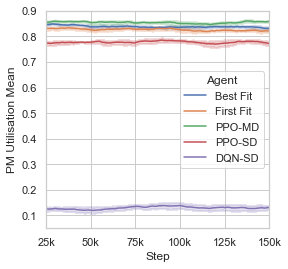

In [71]:
models = {
    'bestfitmd': 'Best Fit',
    'firstfitmd': 'First Fit',
    'ppomd': 'PPO-MD',
    'ppo': 'PPO-SD',
    'dqn': 'DQN-SD',
}

df = pd.DataFrame()
for i in np.arange(0, 10, 1, dtype=int):
    for agent in models.keys():
        f = open(f'data/exp_performance/p10sr1000load1.00/{agent}-{i}.json')
        jsonstr = json.load(f)
        record = Record.import_record(agent, jsonstr)
        sample = pd.DataFrame({'Reward': record.rewards, 'PM Utilisation Mean': np.mean(record.pm_utilisation, axis=1), 'PM Utilisation Std': np.std(record.pm_utilisation, axis=1), 'Waiting Ratio': record.waiting_ratio})
        smooth(sample, ['PM Utilisation Mean', 'PM Utilisation Std', 'Waiting Ratio'])
        sample['Agent'] = models[agent]
        sample['Step'] = sample.index + 1
        df = pd.concat([df, sample])

df = df.reset_index(drop=True)
plt.subplots(figsize=(4,4))
g = sns.lineplot(x="Step", y="PM Utilisation Mean", hue='Agent', data=df)
g.set(xlim=(25000, 150000))
g.set(ylim=(0.05, 0.9))

# Custom x-axis tick formatter
def step_formatter(x, pos):
    return f'{int(x/1000)}k'

g.xaxis.set_major_formatter(ticker.FuncFormatter(step_formatter))

plt.savefig('plots/util_mean_line.pdf', bbox_inches='tight', pad_inches=0.25)


High load PM Utilisation std line graph:

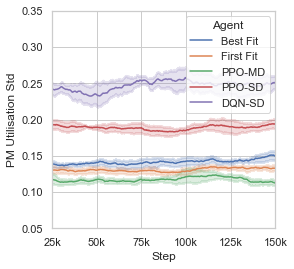

In [72]:
plt.subplots(figsize=(4,4))
g = sns.lineplot(x="Step", y="PM Utilisation Std", hue='Agent', data=df)
g.set(xlim=(25000, 150000))
g.set(ylim=(0.05, 0.35))

# Custom x-axis tick formatter
def step_formatter(x, pos):
    return f'{int(x/1000)}k'

g.xaxis.set_major_formatter(ticker.FuncFormatter(step_formatter))

plt.savefig('plots/util_sd_line.pdf', bbox_inches='tight', pad_inches=0.25)


High load served VMs:

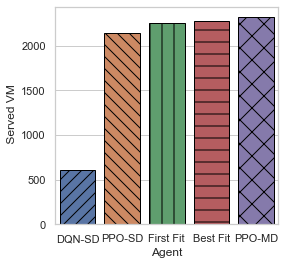

In [5]:
models = {
    'bestfitmd': 'Best Fit',
    'firstfitmd': 'First Fit',
    'ppomd': 'PPO-MD',
    'ppo': 'PPO-SD',
    'dqn': 'DQN-SD',
}
plt.subplots(figsize=(4,4))
df = pd.read_csv('data/exp_performance/summary.csv')
for key in models.keys():
    df.replace(key, models[key], inplace=True)
df = df[(df['Agent'].isin(models.values())) & (df[' Load'] == 1.0) & (df[' Serv Rate'] == 1000)]

g = sns.barplot(x="Agent", y=" Served VM",linewidth=1, edgecolor="0", order=['DQN-SD', 'PPO-SD', 'First Fit', 'Best Fit', 'PPO-MD'], data=df)
hatches = ["//", "\\\\", "|", "-", "x"]
for i, thisbar in enumerate(g.patches):
    thisbar.set_hatch(hatches[i])

plt.savefig('plots/served_bar.pdf', bbox_inches='tight', pad_inches=0.25)

High load drop rate:

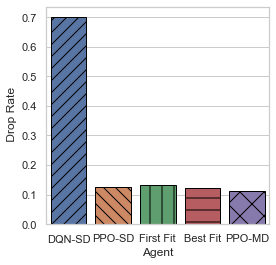

In [6]:
plt.subplots(figsize=(4,4))
g = sns.barplot(x="Agent", y=" Drop Rate",linewidth=1, edgecolor="0", order=['DQN-SD', 'PPO-SD', 'First Fit', 'Best Fit', 'PPO-MD'], data=df)
hatches = ["//", "\\\\", "|", "-", "x"]
for i, thisbar in enumerate(g.patches):
    thisbar.set_hatch(hatches[i])
plt.savefig('plots/drop_bar.pdf', bbox_inches='tight', pad_inches=0.25)

High load waiting ratio: 

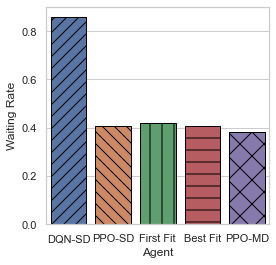

In [7]:
plt.subplots(figsize=(4,4))
g = sns.barplot(x="Agent", y=" Waiting Ratio",linewidth=1, edgecolor="0", order=['DQN-SD', 'PPO-SD', 'First Fit', 'Best Fit', 'PPO-MD'], data=df)
g.set(ylabel='Waiting Rate')
hatches = ["//", "\\\\", "|", "-", "x"]
for i, thisbar in enumerate(g.patches):
    thisbar.set_hatch(hatches[i])
plt.savefig('plots/waiting_bar.pdf', bbox_inches='tight', pad_inches=0.25)

Load vs total served: 

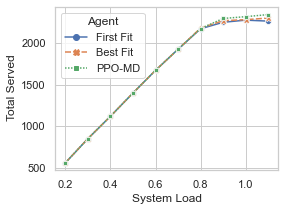

In [16]:
df = pd.read_csv('data/exp_suspension/data.csv')
df['System Load'] = df[' Load']
models = {
    'bestfitmd': 'Best Fit',
    'firstfitmd': 'First Fit',
    'ppomd': 'PPO-MD',
}
for key in models.keys():
    df.replace(key, models[key], inplace=True)
loads = df[(df[' Serv Rate'] == 1000) & (df['Agent'].isin(models.values()))].drop_duplicates()
loads['Suspend Action Ratio'] = loads[' Valid Suspend Actions'] / loads[' Life']
loads['Suspensions per VM'] = loads[' Valid Suspend Actions'] / loads[' Total Served']

plt.subplots(figsize=(4,3))
sns.lineplot(x="System Load", y=" Total Served", markers=True, dashes=True, style='Agent', hue='Agent', data=loads)
plt.savefig('plots/load_served_line.pdf', bbox_inches='tight', pad_inches=0.25)

Load vs Suspensions per vm:

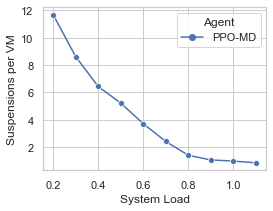

In [36]:
plt.subplots(figsize=(4,3)) 
sns.lineplot(x="System Load", y="Suspensions per VM", markers=True, dashes=True, style='Agent', hue='Agent', data=loads[(loads['Agent'] == 'PPO-MD')])
plt.savefig('plots/load_suspend_per_vm_line.pdf', bbox_inches='tight', pad_inches=0.25)

Load vs pending:

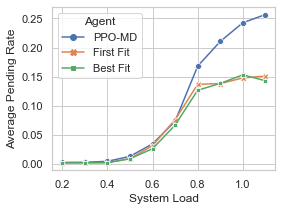

In [37]:
plt.subplots(figsize=(4,3)) 
loads = df[(df[' Serv Rate'] == 1000) & (df['Agent'].isin(models.values()))].drop_duplicates()
g = sns.lineplot(x="System Load", y=" Average Pending", markers=True, dashes=False, style='Agent', hue='Agent', data=loads)
g.set(ylabel='Average Pending Rate')
plt.savefig('plots/load_pending_line.pdf', bbox_inches='tight', pad_inches=0.25)

Load vs slowdown:

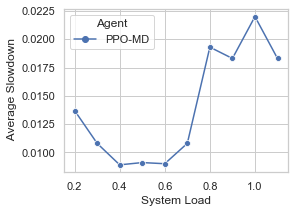

In [38]:
plt.subplots(figsize=(4,3)) 
sns.lineplot(x="System Load", y=" Average Slowdown", markers=True, dashes=True, style='Agent', hue='Agent', data=loads[(loads['Agent'] == 'PPO-MD')])
g.set(ylabel='Average Slowdown Rate')
plt.savefig('plots/load_slowdown_line.pdf', bbox_inches='tight', pad_inches=0.25)

Service Length vs total served:

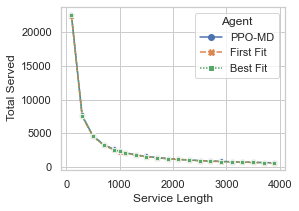

In [39]:
servrates = df[(df[' Load'] == 1) & (df['Agent'].isin(models.values()))].drop_duplicates()
servrates['Suspend Action Ratio'] = servrates[' Valid Suspend Actions'] / servrates[' Life']
servrates['Suspensions per VM'] = servrates[' Valid Suspend Actions'] / servrates[' Total Served']
servrates['Service Length'] = servrates[' Serv Rate']
plt.subplots(figsize=(4,3)) 
sns.lineplot(x="Service Length", y=" Total Served", markers=True, dashes=True, style='Agent', hue='Agent', data=servrates)
plt.savefig('plots/service_length_served_line.pdf', bbox_inches='tight', pad_inches=0.25)

Service length vs suspend action ratio: 

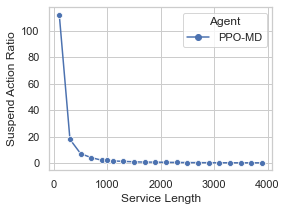

In [40]:
plt.subplots(figsize=(4,3)) 
sns.lineplot(x="Service Length", y="Suspend Action Ratio", markers=True, dashes=True, style='Agent', hue='Agent', data=servrates[(servrates['Agent'] == 'PPO-MD')])
plt.savefig('plots/service_length_suspend_ratio_line.pdf', bbox_inches='tight', pad_inches=0.25)

Service length vs suspend action ratio: 

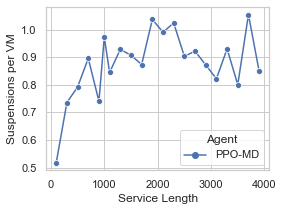

In [41]:
plt.subplots(figsize=(4,3)) 
g = sns.lineplot(x="Service Length", y="Suspensions per VM", markers=True, dashes=True, hue='Agent', style='Agent', data=servrates[(servrates['Agent'] == 'PPO-MD')])
plt.savefig('plots/service_length_suspend_per_vm_line.pdf', bbox_inches='tight', pad_inches=0.25)

Service length vs pending:

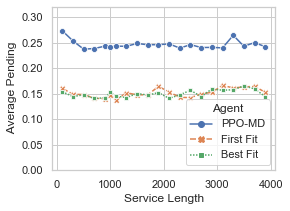

In [42]:
plt.subplots(figsize=(4,3)) 
g = sns.lineplot(x="Service Length", y=" Average Pending", markers=True, dashes=True, style='Agent', hue='Agent', data=servrates)
g.set(ylim=(0, 0.32))
plt.savefig('plots/service_length_pending_line.pdf', bbox_inches='tight', pad_inches=0.25)

Service length vs slowdown:

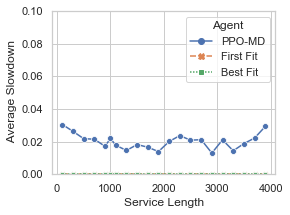

In [43]:
plt.subplots(figsize=(4,3)) 
g = sns.lineplot(x="Service Length", y=" Average Slowdown", markers=True, dashes=True, style='Agent', hue='Agent', data=servrates)
g.set(ylim=(0, 0.1))
plt.savefig('plots/service_length_pending_line.pdf', bbox_inches='tight', pad_inches=0.25)

Slowdown rate distribution

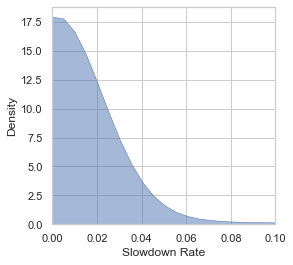

In [73]:
f = open(f'data/exp_performance/p10sr1000load1.00/weights/ppomd-r1-0.json')
jsonstr = json.load(f)
record = Record.import_record('PPO', jsonstr)
slowdowns = np.array(record.slowdown_rates)
plt.figure(figsize=(4, 4))
g = sns.kdeplot(data=slowdowns, fill=True, common_norm=False, alpha=0.5, linewidth=0.5)
g.set(ylabel='Density')
g.set(xlabel='Slowdown Rate')
g.set(xlim=(0, 0.1))
plt.savefig('plots/slowdown_kde.pdf', bbox_inches='tight', pad_inches=0.25)

/var/folders/wj/_8blp7yj4d5c6ghh_knwzdf40000gn/T/ipykernel_13634/1518349505.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(['', '0', '20K', '40K', '60K', '80K', '100K'])


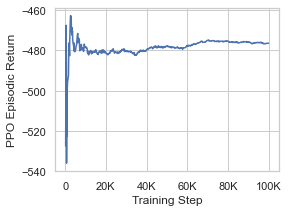

In [45]:
# Extract from tensorboard log
df = pd.read_csv('data/exp_training/ppomd-r1.csv')
smooth(df, ['Value'])
df.reset_index(inplace=True)

plt.subplots(figsize=(4,3))
g = sns.lineplot(x=df['Step']*500, y=df['Value'])
g.set(ylabel='PPO Episodic Return')
g.set(xlabel='Training Step')
g.set_xticklabels(['', '0', '20K', '40K', '60K', '80K', '100K'])
g.set_yticks(np.arange(-540, -440, 20))
plt.savefig('plots/ppo-return.pdf', bbox_inches='tight', pad_inches=0.25)

/var/folders/wj/_8blp7yj4d5c6ghh_knwzdf40000gn/T/ipykernel_13634/1100638095.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(['', '0', '20K', '40K', '60K', '80K', '100K'])


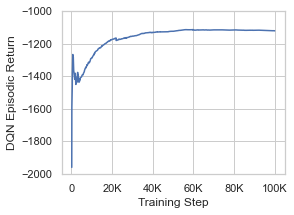

In [46]:
# Extract from tensorboard log
df = pd.read_csv('data/exp_training/dqn-r1.csv')
smooth(df, ['Value'])
df.reset_index(inplace=True)

plt.subplots(figsize=(4,3))
g = sns.lineplot(x=df['Step']*500, y=df['Value'])
g.set(ylabel='DQN Episodic Return')
g.set(xlabel='Training Step')
g.set_xticklabels(['', '0', '20K', '40K', '60K', '80K', '100K'])
g.set_yticks(np.arange(-2000, -800, 200))
plt.savefig('plots/dqn-return.pdf', bbox_inches='tight', pad_inches=0.25)

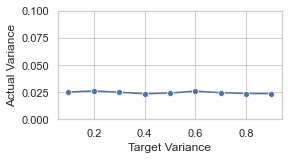

In [69]:
means = []
vars = []
targets = np.around(np.arange(0.01, 1, 0.05), decimals=2)
for i in targets:
    f = open(f'data/exp_var/{i:.2f}.json')
    jsonstr = json.load(f)
    record = Record.import_record('PPO', jsonstr)
    utils = record.pm_utilisation
    utils = np.array(utils)
    mean = np.mean(utils)
    var = np.var(utils)
    means.append(mean)
    vars.append(var)

plt.subplots(figsize=(4,2))
g = sns.lineplot(x=targets, y=vars, marker='o')
g.set(ylabel='Actual Variance')
g.set(xlabel='Target Variance')
g.set(ylim=(0, 0.1))
plt.savefig('plots/sd_sd.pdf', bbox_inches='tight')

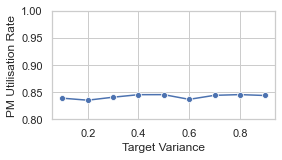

In [70]:
plt.subplots(figsize=(4,2))
g = sns.lineplot(x=targets, y=means, marker='o')
g.set(ylabel='PM Utilisation Rate')
g.set(xlabel='Target Variance')
g.set(ylim=(0.8, 1))
plt.savefig('plots/sd_mean.pdf', bbox_inches='tight')